In [3]:
import requests

import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

import sklearn.feature_extraction.text as sktext
import sklearn.neighbors as skneigh
import sklearn.manifold as skmani

%matplotlib inline

In [4]:
def attr_parser(item_attrs, cat_attrs):
    # Parsea los atributes preservando orden
    parsed = []
    for base_attr in cat_attrs:
        attr_id = base_attr['id'] 

        # Look for attribute
        attribute_found = False
        for attr in item_attrs:
            if attr['id'] == attr_id:
                value_type = base_attr['value_type']
                try:
                    if   value_type == 'number':
                        parsed.append(float(attr['value_name']))
                    elif value_type == 'number_unit':
                        # TODO: conversor de unidades
                        parsed.append(attr['value_struct']['number']) 
                    elif value_type == 'string':
                        # TODO: apply tokenizer to attribute
                        parsed.append(float(attr['value_id']))
                    elif value_type == 'boolean':
                        parsed.append(1.0 if attr['value_id']=='242085' else 0.0)
                    elif value_type == 'list':
                        # TODO: implement list parsing
                        parsed.append(0.0)
                except:
                    parsed.append(0.0)
                
                attribute_found = True
                break

        # Attribute not found
        if not attribute_found:
            parsed.append(0.0)
    
    return parsed

In [5]:
# Target
site_id = 'MLA'

example = 'pila'
target_id = f'{site_id}1100783124'

example = 'multiproc'
target_id = f'{site_id}1101556021'

In [6]:
# 1 - Get item
# Extract info from target item
url  = f'https://api.mercadolibre.com/items/{target_id}'
req  = requests.get(url)
info = req.json()
target = info['title']

print(target)

Multiprocesadora Smartlife Sl-fp0509 1000w Negra Y Acero Inoxidable 220v - 240v


Obtengo la categoría y busco sus atributos. Para expandir el universo de posibilidades una opción podría ser buscar en que otras categorías se podría encontrar el item mediante la funcioón de _domain discovery_ de la API

In [7]:
# 2 - Get categoy and attributes
cat_id = info['category_id']
url = f'https://api.mercadolibre.com/categories/{cat_id}/attributes'
req = requests.get(url)
cat_attrs = req.json()
target_attr = attr_parser(info['attributes'], cat_attrs)
target_attr = np.array(target_attr).reshape(1,-1)

In [8]:
# 3 - Get items in categories
limit = 50
items = []

url = f'https://api.mercadolibre.com/sites/{site_id}/search?category={cat_id}'
req = requests.get(url)
total = req.json()['paging']['total']

if total>1000: total = 1000 # Sin AUTHTOKEN no deja ver más de 1000 registros
total = 200 ##### ACTUALIZAR ESTO DESPUES

items = items + req.json()['results']
for offset in range(limit, total, limit):
    url = f'https://api.mercadolibre.com/sites/{site_id}/search?category={cat_id}&offset={offset}'
    req = requests.get(url)
    items = items + req.json()['results']

Se podría crear un diccionario más grande viendo las descripciones en /items/{item_id}/description

In [11]:
# Extract features from items
titles      = []
item_ids    = []
attributes  = []
for unit in items:
    url  = f'https://api.mercadolibre.com/items/{unit["id"]}'
    req  = requests.get(url)
    info = req.json()
    try:
        item_ids.append(info['id'])
        titles.append(info['title'])
        attributes.append(attr_parser(info['attributes'], cat_attrs))
    except KeyError:
        pass
    
titles     = np.array(titles)
item_ids   = np.array(item_ids)
attributes = np.array(attributes)

In [12]:
np.save(f'titles_{example}', titles)
np.save(f'attris_{example}', attributes)
#titles = np.load(f'titles_{example}.npy')
#attributes = np.load(f'attris_{example}.npy')

# Arranco con ML

## Agrupación por texto

In [13]:
# Tokenizo los títulos
count_vect = sktext.CountVectorizer()
tfidf_tran = sktext.TfidfTransformer()

X = count_vect.fit_transform(titles)
X = tfidf_tran.fit_transform(X)

In [24]:
# Armo el mapa
nnalg_text = skneigh.NearestNeighbors()
nnalg_text.fit(X)

NearestNeighbors()

In [25]:
# Realizo la predicción
ll=[]

predict = count_vect.transform([target])
X_tfidf2 = tfidf_tran.transform(predict)
ll.append(X_tfidf2)

ll = scipy.sparse.vstack((ll))
res = nnalg_text.kneighbors(ll, return_distance=False)

print(np.array(titles)[res[0]])

['Multiprocesadora Smartlife Sl-fp0509 1000w Negra Y Acero Inoxidable 220v - 240v'
 'Procesadora De Alimentos Smartlife Sl-fp0509 1000w Acero '
 'Multiprocesadora Smartlife Licuadora  Acero Inoxidable 1000w'
 'Multiprocesadora Smartlife Con Licuadora 1000w Fp509 Acero'
 'Multiprocesadora Liliana Fullpros Am790 1000w Negra 220v - 240v']


In [41]:
total_text_dist, total_text_idxs = nnalg_text.kneighbors(X)

## Agrupación por atributos

In [44]:
# Armo el mapa
attributes = attributes/attributes.max()
nnalg_attr = skneigh.NearestNeighbors()
nnalg_attr.fit(attributes)

NearestNeighbors()

In [45]:
# Realizo la predicción
res = nnalg_attr.kneighbors(target_attr, return_distance=False)
print(np.array(titles)[res[0]])

['Multiprocesadora Kitchenaid Kfp0919 250w Empire Red 220v - 400v'
 'Multiprocesadora Kitchenaid Kfp0919 250w Onyx Black 220v - 400v'
 'Multiprocesadora Black Decker Fp1002 750w 3 Velocidades'
 'Multiprocesadora Black Decker Fp1002 3 Veloc 1250ml 750w'
 'Multiprocesadora Smartlife Sl-fp0509 1000w Negra Y Acero Inoxidable 220v - 240v']


In [46]:
total_attr_dist, total_attr_idxs = nnalg_attr.kneighbors(attributes)

## Comparación

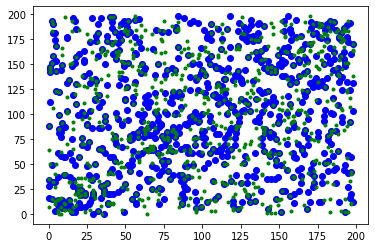

In [49]:
plt.plot(total_attr_idxs[:,1:], 'bo')
plt.plot(total_text_idxs[:,1:], 'g.')

In [64]:
np.sum(np.sort(total_attr_idxs[:,1:])==np.sort(total_text_idxs[:,1:]),axis=1)

array([1, 3, 2, 2, 0, 1, 0, 3, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 3, 0, 1, 2, 1, 0, 1, 2,
       1, 0, 0, 0, 0, 1, 2, 0, 1, 3, 1, 0, 0, 0, 2, 0, 0, 1, 0, 1, 1, 0,
       2, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 3, 2, 1, 0, 1, 0, 0, 1, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 2, 3, 0, 0,
       1, 0, 1, 0, 2, 0, 1, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0, 2, 3, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1])

In [79]:
ii = 43
print(np.array(titles)[total_attr_idxs[ii]],'\n',np.array(titles)[total_text_idxs[ii]])

['Smart-tek Sm2026 Easy Chop Rebanador Cortador Rallador Acero'
 'Smartek Sm3026 Rallador Rebanador De Verduras 150w'
 'Procesadora Picadora Smart Tek De Alimento Vidrio Mini 2 Vel'
 'Rallador Rebanador Electrico Smart-tek Easychop Sm3026 150w '
 'Rallador Eléctrico Smart-tek Easy Chop Verduras Queso Rebanador'] 
 ['Smart-tek Sm2026 Easy Chop Rebanador Cortador Rallador Acero'
 'Rallador Eléctrico Smart-tek Easy Chop Verduras Queso Rebanador'
 ' Rebanador Electrico Easy Chop Verduras Queso Rallador'
 'Rallador Rebanador Electrico Smart-tek Easychop Sm3026 150w '
 'Procesadora Picadora Smart Tek De Alimento Vidrio Mini 2 Vel']


# Visulizaciones

In [ ]:
tsne = skmani.TSNE(n_components=2)
tsne_results = tsne.fit_transform(X)

In [ ]:
data = {}
data['tsne-2d-one'] = tsne_results[:,0]
data['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.3
)
for ii in res[0]:
    plot(data['tsne-2d-one'][ii], data['tsne-2d-two'][ii], 'o')
